**Dataset Handling and Loading**

In [ ]:
import zipfile

# Define paths
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/APS360 Team 5 Project/dataset_new.zip'
extract_path = '/content/extracted_dataset_new'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to", extract_path)

Mounted at /content/drive
Dataset extracted to /content/extracted_dataset_new


# Data Loading and Splitting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Image Transformation**

Apply rotation, padding, brightness change, and resize to 224x224.
224x224. Most widely used pretrained CNNs (like ResNet, VGG, AlexNet) expect an input size of 224x224, which allows easy use of these architectures for transfer learning.

The original images are 480x640

In [ ]:
from torchvision import transforms

# Define transformations for 640x480 images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


**Load the data**

In [ ]:
from torchvision import datasets

dataset_path = '/content/extracted_dataset_new/dataset_new'
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

class_names = dataset.classes
print("Classes:", class_names)


Classes: ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']


**Split Data**

80/10/10 split

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define dataset split sizes
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.seed(1000)
np.random.shuffle(indices)

# 80/10/10
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Dataloaders
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, drop_last=True)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, drop_last=True)

print("Number of training samples:", len(train_indices))
print("Number of validation samples:", len(val_indices))
print("Number of test samples:", len(test_indices))


Number of training samples: 22400
Number of validation samples: 2800
Number of test samples: 2800


**A few sample images for display**

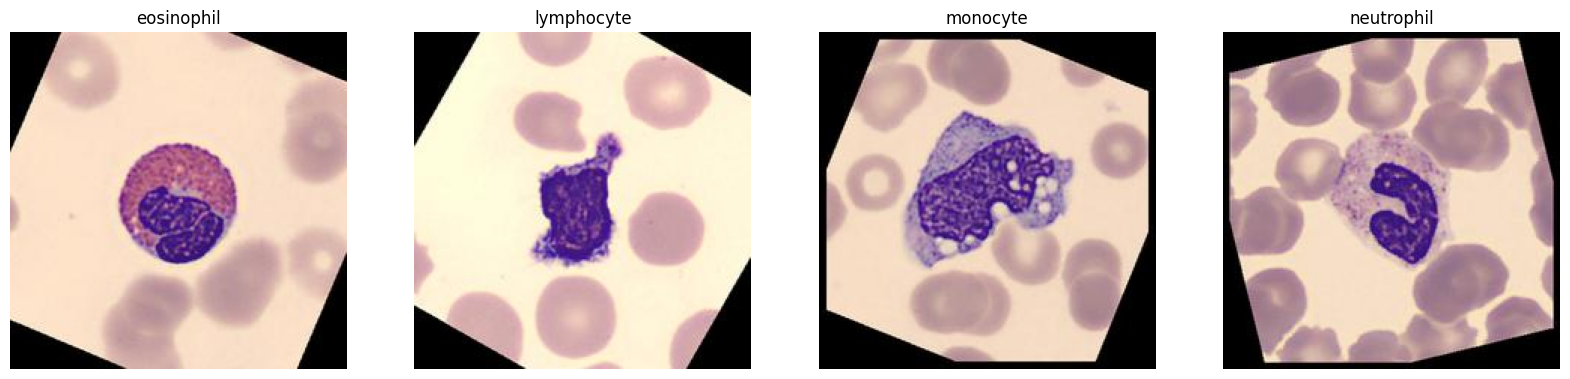

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, len(class_names), figsize=(20, 10))
for idx, class_name in enumerate(class_names):
    for img, label in train_loader:
        if label[0] == idx:
            axes[idx].imshow(img[0].permute(1, 2, 0) * 0.5 + 0.5)
            axes[idx].set_title(class_name)
            axes[idx].axis("off")
            break
plt.show()



**Baseline Model**

In [ ]:
!pip install cuml-cu11 --extra-index-url=https://pypi.ngc.nvidia.com


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproje

In [ ]:
use_cuda = True

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from cuml.svm import SVC as cuSVC  # GPU-accelerated SVM from cuML

# Paths
data_path = '/content/extracted_dataset_new/dataset_new'
classes = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']

# Feature extraction functions
def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def extract_edge_features(image):
    edges = cv2.Canny(image, 100, 200)
    return edges.flatten()

# Load dataset and extract features
features = []
labels = []

for class_idx, class_name in enumerate(classes):
    class_folder = os.path.join(data_path, class_name)
    for img_name in os.listdir(class_folder):
        img_path = os.path.join(class_folder, img_name)
        image = cv2.imread(img_path)
        image = cv2.resize(image, (128, 128))  # Resize for uniformity

        # Extract features
        color_hist = extract_color_histogram(image)
        edge_features = extract_edge_features(image)

        # Concatenate features
        feature_vector = np.hstack([color_hist, edge_features])
        features.append(feature_vector)
        labels.append(class_idx)

# Convert to NumPy arrays
features = np.array(features).astype(np.float32)  # Convert to float32 for cuML
labels = np.array(labels).astype(np.int32)       # Convert to int32 for cuML

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# GPU-Accelerated SVM Classifier
svm = cuSVC(kernel='linear', C=1.0)
svm.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = svm.predict(X_test).astype(np.int32)  # Convert predictions to int32 for compatibility
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=classes))


ModuleNotFoundError: No module named 'cuml'

**Primary Model**

In [ ]:
import os
import torch
import torchvision.models
resnet = torchvision.models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


In [ ]:
directory = '/content/extracted_dataset_new/dataset_new'
classes = ['eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
resnet_features = torch.nn.Sequential(
    *list(resnet.children())[:-1],
    torch.nn.AdaptiveAvgPool2d((1, 1))  # Add global average pooling to reduce spatial dimensions
)



In [ ]:
use_cuda = True

In [ ]:
if torch.cuda.is_available():
    resnet_features = resnet_features.cuda()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def save_resnet_features(dataloader, set_name, directory):
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs, lbls = imgs.to(device), lbls.to(device)

            # Extract features
            feature = resnet_features(imgs)
            features.append(feature)
            labels.append(lbls)

    features = torch.cat(features)
    labels = torch.cat(labels)

    print(f"Saving features of shape {features.shape} and labels of shape {labels.shape}")
    torch.save(features, os.path.join(directory, f'{set_name}_features.pt'))
    torch.save(labels, os.path.join(directory, f'{set_name}_labels.pt'))




In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ResNetClassifier(nn.Module):
    def __init__(self, dropout_rate=0.3):  # Add `dropout_rate` parameter
        super(ResNetClassifier, self).__init__()
        self.fc1 = nn.Linear(2048, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(dropout_rate)  # Use tunable dropout

        self.fc2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)  # Use tunable dropout

        self.fc3 = nn.Linear(128, 4)  # Output for 4 classes

    def forward(self, x):
      x = torch.flatten(x, 1)  # Flatten the tensor while keeping the batch size
      x = F.relu(self.bn1(self.fc1(x)))  # First fully connected layer
      x = self.dropout1(x)  # Apply dropout
      x = F.relu(self.bn2(self.fc2(x)))  # Second fully connected layer
      x = self.dropout2(x)  # Apply dropout
      x = self.fc3(x)  # Output layer
      return x




In [ ]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(classifier, train_features, train_labels, val_features, val_labels, learning_rate=0.001, batch_size=64, num_epochs=30, weight_decay=0.0): #added weight decay param
    optimizer = optim.Adam(classifier.parameters(), lr=learning_rate, weight_decay=weight_decay) # added weight decay here
    criterion = nn.CrossEntropyLoss()

    # Prepare DataLoaders for the extracted features
    train_data = torch.utils.data.TensorDataset(train_features, train_labels)
    val_data = torch.utils.data.TensorDataset(val_features, val_labels)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Initialize tracking lists
    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], [] # Initialize lists to store losses

    for epoch in range(num_epochs):
        classifier.train()
        total_train_loss = 0

        # Training phase
        correct_train = 0
        total_train = 0
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            # Calculate training accuracy
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_loss_list.append(avg_train_loss)

        # Validation phase
        classifier.eval()
        correct_val = 0
        total_val = 0
        total_val_loss = 0 # Initialize total validation loss for the epoch
        with torch.no_grad():
            for features, labels in val_loader:
                features, labels = features.to(device), labels.to(device)
                outputs = classifier(features)
                loss = criterion(outputs, labels) # Calculate validation loss
                total_val_loss += loss.item() # Accumulate validation loss

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # Calculate average validation loss for the epoch
        avg_val_loss = total_val_loss / len(val_loader)
        val_loss_list.append(avg_val_loss)

        # Calculate and store accuracy
        train_acc = 100 * correct_train / total_train
        val_acc = 100 * correct_val / total_val
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Accuracy: {train_acc:.2f}%, "
              f"Validation Accuracy: {val_acc:.2f}%, "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {avg_val_loss:.4f}")

    return train_acc_list, val_acc_list, num_epochs, train_loss_list, val_loss_list # Return both loss lists

In [ ]:
def get_accuracy(model, data_loader, feature_extractor=None):  # Add feature_extractor argument
    correct = 0
    total = 0

    model.eval()
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            if feature_extractor:
                imgs = feature_extractor(imgs)  # Extract features if provided

            imgs = torch.flatten(imgs, 1)  # Flatten the feature vectors (if not already)

            outputs = model(imgs)  # Use features instead of raw images
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    return correct / total

In [ ]:
net = ResNetClassifier(dropout_rate=0.25)  # Use the tuned dropout_rate

if use_cuda and torch.cuda.is_available():
    net.cuda()

#classifier, train_features, train_labels, val_features, val_labels, learning_rate=0.001, batch_size=32, num_epochs=10
train_features = torch.load(os.path.join(directory, 'train_features.pt'))
train_labels = torch.load(os.path.join(directory, 'train_labels.pt'))
val_features = torch.load(os.path.join(directory, 'val_features.pt'))
val_labels = torch.load(os.path.join(directory, 'val_labels.pt'))

train_acc_list, val_acc_list, epochs, train_loss, val_loss = train(
    net,
    train_features,
    train_labels,
    val_features,
    val_labels,
    learning_rate=1.6782665789937792e-05,  # Tuned learning rate
    batch_size=32,  # Tuned batch size
    num_epochs=30,  # Number of epochs remains the same
    weight_decay=0.005624762326016132  # Tuned weight decay
)




# Test Accuracy
test_acc = get_accuracy(net, test_loader, feature_extractor=resnet_features)  # Pass resnet_features
print("Test Accuracy: ", test_acc)

# Validation Accuracy
val_acc = get_accuracy(net, val_loader, feature_extractor=resnet_features)  # Pass resnet_features
print("Validation Accuracy: ", val_acc)




<ipython-input-15-eb0588e6e22d>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_features = torch.load(os.path.join(directory, 'train_features.pt'))
<ipython-input-15-

Epoch [1/30], Train Accuracy: 78.29%, Validation Accuracy: 91.95%, Train Loss: 0.7029, Validation Loss: 0.3976
Epoch [2/30], Train Accuracy: 91.38%, Validation Accuracy: 93.35%, Train Loss: 0.3676, Validation Loss: 0.2930
Epoch [3/30], Train Accuracy: 93.05%, Validation Accuracy: 94.22%, Train Loss: 0.2827, Validation Loss: 0.2359
Epoch [4/30], Train Accuracy: 93.86%, Validation Accuracy: 94.22%, Train Loss: 0.2389, Validation Loss: 0.2190
Epoch [5/30], Train Accuracy: 94.40%, Validation Accuracy: 94.97%, Train Loss: 0.2109, Validation Loss: 0.1813
Epoch [6/30], Train Accuracy: 95.39%, Validation Accuracy: 95.65%, Train Loss: 0.1790, Validation Loss: 0.1626
Epoch [7/30], Train Accuracy: 95.96%, Validation Accuracy: 95.87%, Train Loss: 0.1569, Validation Loss: 0.1484
Epoch [8/30], Train Accuracy: 96.31%, Validation Accuracy: 95.94%, Train Loss: 0.1426, Validation Loss: 0.1349
Epoch [9/30], Train Accuracy: 96.89%, Validation Accuracy: 96.23%, Train Loss: 0.1259, Validation Loss: 0.1337
E

Save the model for future use

In [ ]:
import torch

# Define the path to save the model
model_save_path = '/content/drive/MyDrive/APS360 Team 5 Project/trained_resnet_model.pth'

# Save the trained model's state_dict
torch.save(net.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to /content/drive/MyDrive/APS360 Team 5 Project/trained_resnet_model.pth


Save the model for future use

In [ ]:
# Generate a list of epoch numbers
epoch_range = range(1, epochs + 1)

# Plot training accuracy
plt.plot(epoch_range, train_acc_list, label="Training Accuracy")
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot validation accuracy
plt.plot(epoch_range, val_acc_list, label="Validation Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

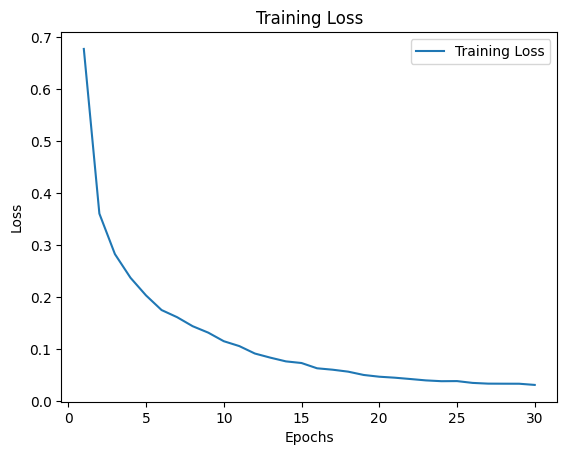

In [ ]:


plt.plot(epoch_range, train_loss, label="Training Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


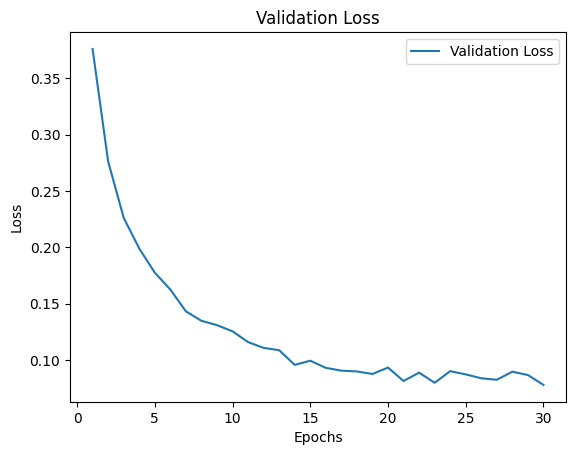

In [ ]:
plt.plot(epoch_range, val_loss, label="Validation Loss")
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Objective Function with Optuna Integration to Fine-Tune hyperparameters

In [ ]:
!pip install optuna

In [ ]:
import optuna
from torch.utils.data import DataLoader

def objective(trial):
    # Suggest hyperparameters
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.05)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)

    # Create the model
    model = ResNetClassifier(dropout_rate=dropout_rate).to(device)

    # Define optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    # Prepare DataLoaders
    train_data = torch.utils.data.TensorDataset(train_features, train_labels)
    val_data = torch.utils.data.TensorDataset(val_features, val_labels)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Train the model
    num_epochs = 30  # Use fewer epochs for faster tuning
    for epoch in range(num_epochs):
        model.train()
        for features, labels in train_loader:
            features, labels = features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for features, labels in val_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_accuracy = correct / total  # Calculate validation accuracy
    return val_accuracy  # Optuna will maximize this value


Run the optimization, find the best hyper-parameters combo

In [ ]:
# Create an Optuna study and run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

# Print the best hyperparameters
print("Best Hyperparameters:")
print(study.best_params)
print(f"Best Validation Accuracy: {study.best_value:.4f}")


[I 2024-11-24 21:27:40,819] A new study created in memory with name: no-name-c6600c09-7324-486b-9b3a-58655e085c2e
<ipython-input-34-48161e303d68>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
<ipython-input-34-48161e303d68>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-2)
[I 2024-11-24 21:28:42,285] Trial 0 finished with value: 0.9760714285714286 and parameters: {'dropout_rate': 0.35000000000000003, 'batch_size': 32, 'learning_rate': 1.5300878687693633e-05, 'weight_decay': 0.004990300219653098}. Best is trial 0 with value: 0.976071

Best Hyperparameters:
{'dropout_rate': 0.35000000000000003, 'batch_size': 32, 'learning_rate': 1.5300878687693633e-05, 'weight_decay': 0.004990300219653098}
Best Validation Accuracy: 0.9761


Train the model with the best combo we have found so far:
- Test Accuracy:  0.9806034482758621
- Validation Accuracy:  0.9780890804597702

Test the current model on a unseen dataset

Unzip the unseen dataset

In [ ]:
import zipfile
import shutil # Import the shutil module


# Define paths
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/APS360 Team 5 Project/dataset_unseen.zip'
extract_path = '/content/extracted_dataset_unseen'

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to", extract_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset extracted to /content/extracted_dataset_unseen


**Prepare the unseen data**

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler
import numpy as np

# Define dataset split sizes
dataset_size = len(dataset)
indices = list(range(dataset_size))
np.random.seed(1000)
np.random.shuffle(indices)

# 80/10/10
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# Dataloaders
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, drop_last=True)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, drop_last=True)

print("Number of training samples:", len(train_indices))
print("Number of validation samples:", len(val_indices))
print("Number of test samples:", len(test_indices))

Number of training samples: 22400
Number of validation samples: 2800
Number of test samples: 2800


In [ ]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the data transformations

transform_unseen = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the unseen dataset
unseen_dataset_path = '/content/extracted_dataset_unseen/dataset_unseen'
unseen_dataset = datasets.ImageFolder(root=unseen_dataset_path, transform=transform_unseen)

# Define dataset split sizes
unseen_dataset_size = len(unseen_dataset)
unseen_indices = list(range(unseen_dataset_size))
np.random.seed(1000)
np.random.shuffle(unseen_indices)

unseen_sampler = SubsetRandomSampler(unseen_indices)
unseen_loader = DataLoader(unseen_dataset, batch_size=32, sampler=unseen_sampler, drop_last=True)

print("Number of unseen samples:", len(unseen_indices))

# Extract ResNet features for unseen dataset
#save_resnet_features(unseen_loader, 'unseen', '/content/dataset_unseen/dataset_unseen')

Number of unseen samples: 9042


In [ ]:
# Reload the trained model
net = ResNetClassifier(dropout_rate=0.25)

model_save_path = '/content/drive/MyDrive/APS360 Team 5 Project/trained_resnet_model.pth'
net.load_state_dict(torch.load(model_save_path))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)
net.eval()

# Evaluate the model on the unseen dataset
unseen_acc = get_accuracy(net, unseen_loader, feature_extractor= resnet_features)
print(f"Unseen Dataset Accuracy: {unseen_acc * 100:.2f}%")

<ipython-input-30-8987f31a8bc0>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(model_save_path))


Unseen Dataset Accuracy: 75.35%
